# Pipeline processing

This notebook demonstrates the continuum imaging and ICAL pipelines.

In [1]:
% matplotlib inline

import os
import sys

sys.path.append(os.path.join('..', '..'))

results_dir = './results'
os.makedirs(results_dir, exist_ok=True)

from matplotlib import pylab

pylab.rcParams['figure.figsize'] = (12.0, 12.0)
pylab.rcParams['image.cmap'] = 'rainbow'

import numpy

from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.wcs.utils import pixel_to_skycoord

from matplotlib import pyplot as plt

from data_models.polarisation import PolarisationFrame
from data_models.parameters import get_parameter

from wrappers.serial.calibration.calibration import solve_gaintable
from wrappers.serial.calibration.operations import apply_gaintable, create_gaintable_from_blockvisibility
from wrappers.serial.visibility.base import create_blockvisibility
from wrappers.serial.skycomponent.operations import create_skycomponent
from wrappers.serial.image.operations import show_image, export_image_to_fits, qa_image
from wrappers.serial.visibility.iterators import vis_timeslice_iter
from wrappers.serial.visibility.coalesce import convert_visibility_to_blockvisibility
from wrappers.serial.visibility.operations import qa_visibility
from wrappers.serial.simulation.testing_support import create_named_configuration, create_low_test_image_from_gleam, \
    simulate_gaintable
from wrappers.serial.imaging.base import create_image_from_visibility, advise_wide_field
from workflows.serial.imaging.imaging_serialimport invert_serial, predict_serial
from workflows.serial.pipelines.pipeline_serial import ical_serial

import logging

log = logging.getLogger()
log.setLevel(logging.INFO)
log.addHandler(logging.StreamHandler(sys.stdout))


We create a graph to make the visibility. The parameter rmax determines the distance of the furthest antenna/stations used. All over parameters are determined from this number.

In [2]:
nfreqwin=5
ntimes=11
rmax=300.0
frequency=numpy.linspace(0.8e8,1.2e8,nfreqwin)
channel_bandwidth=numpy.array(nfreqwin*[frequency[1]-frequency[0]])
times = numpy.linspace(-numpy.pi/3.0, numpy.pi/3.0, ntimes)
phasecentre=SkyCoord(ra=+30.0 * u.deg, dec=-60.0 * u.deg, frame='icrs', equinox='J2000')

lowcore = create_named_configuration('LOWBD2-CORE', rmax=rmax)

block_vis = create_blockvisibility(lowcore, times, frequency=frequency, channel_bandwidth=channel_bandwidth,
                     weight=1.0, phasecentre=phasecentre,
                     polarisation_frame=PolarisationFrame("stokesI"))

create_blockvisibility: 11 rows, 0.015 GB


In [3]:
wprojection_planes=1
advice=advise_wide_field(block_vis, guard_band_image=4.0, delA=0.02,
                             wprojection_planes=wprojection_planes)

vis_slices = advice['vis_slices']
npixel=advice['npixels2']
cellsize=advice['cellsize']

advise_wide_field: Maximum wavelength 3.747 (meters)
advise_wide_field: Minimum wavelength 2.498 (meters)
advise_wide_field: Maximum baseline 229.0 (wavelengths)
advise_wide_field: Station/antenna diameter 35.0 (meters)
advise_wide_field: Primary beam 0.107069 (rad) 6.135 (deg)
advise_wide_field: Image field of view 0.428275 (rad) 24.538 (deg)
advise_wide_field: Synthesized beam 0.004366 (rad) 0.250 (deg)
advise_wide_field: Cellsize 0.001455 (rad) 0.083 (deg)
advice_wide_field: Npixels per side = 294
advice_wide_field: Npixels (power of 2, 3) per side = 384
advice_wide_field: W sampling for full image = 0.3 (wavelengths)
advice_wide_field: W sampling for primary beam = 5.6 (wavelengths)
advice_wide_field: Time sampling for full image = 41.7 (s)
advice_wide_field: Time sampling for primary beam = 666.8 (s)
advice_wide_field: Frequency sampling for full image = 57881.5 (Hz)
advice_wide_field: Frequency sampling for primary beam = 926104.3 (Hz)
advice_wide_field: Number of planes in w sta

In [4]:
gleam_model = create_low_test_image_from_gleam(npixel=npixel, frequency=frequency,
    channel_bandwidth=channel_bandwidth, cellsize=cellsize, phasecentre=phasecentre, applybeam=True, flux_limit=1.0)

create_low_test_skycomponents_from_gleam: 514 sources above flux limit 1.000
create_low_test_beam: primary beam is defined at 100.000 MHz
Quality assessment:
	Origin: qa_image
	Context: create_low_test_image_from_gleam
	Data:
		shape: '(5, 1, 384, 384)'
		max: '8.118122186797462'
		min: '0.0'
		rms: '0.02872062898847828'
		sum: '278.25643510925676'
		medianabs: '0.0'
		median: '0.0'



In [5]:
export_image_to_fits(gleam_model, '%s/imaging-ical_gleam_model.fits'
                     % (results_dir))

In [6]:
block_vis = predict_serial(block_vis, gleam_model, vis_slices=51, context='wstack')
gt = create_gaintable_from_blockvisibility(block_vis)
gt = simulate_gaintable(gt, phase_error=1.0)
block_vis = apply_gaintable(block_vis, gt)

In [7]:
model = create_image_from_visibility(block_vis, npixel=npixel, frequency=[numpy.average(frequency)], nchan=1,
    channel_bandwidth=[numpy.sum(channel_bandwidth)], cellsize=cellsize, phasecentre=phasecentre)

create_image_from_visibility: Parsing parameters to get definition of WCS
create_image_from_visibility: Defining single channel MFS Image at <SkyCoord (ICRS): (ra, dec) in deg
    (30., -60.)>, starting frequency 100000000.0 Hz, and bandwidth [50000000.] Hz
create_image_from_visibility: uvmax = 101.803178 wavelengths
create_image_from_visibility: Critical cellsize = 0.004911 radians, 0.281405 degrees
create_image_from_visibility: Cellsize          = 0.001455 radians, 0.083383 degrees


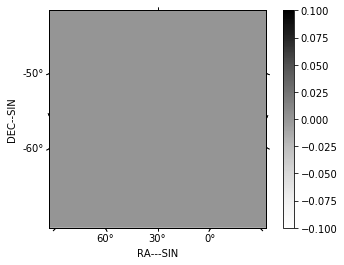

In [8]:
show_image(model)
plt.show()

In [9]:
export_image_to_fits(model, '%s/imaging-ical_model.fits'
                     % (results_dir))

In [10]:
print(qa_image(model, "Model field"))

Quality assessment:
	Origin: qa_image
	Context: Model field
	Data:
		shape: '(1, 1, 384, 384)'
		max: '0.0'
		min: '0.0'
		rms: '0.0'
		sum: '0.0'
		medianabs: '0.0'
		median: '0.0'



In [11]:
dirty, sumwt = invert_serial(block_vis, model, vis_slices=vis_slices, dopsf=False, context='wstack')

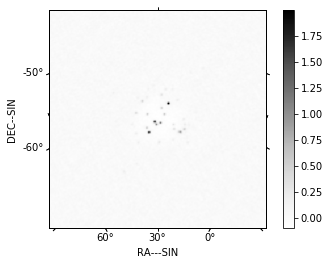

In [12]:
show_image(dirty)
plt.show()

In [13]:
export_image_to_fits(dirty, '%s/imaging-ical_dirty.fits'
                     % (results_dir))

In [14]:
print(qa_image(dirty, "Dirty field"))

Quality assessment:
	Origin: qa_image
	Context: Dirty field
	Data:
		shape: '(1, 1, 384, 384)'
		max: '1.9942608228778638'
		min: '-0.09609022267350019'
		rms: '0.03673681723833111'
		sum: '-7.727443859253343'
		medianabs: '0.010999377204333898'
		median: '-0.0011684229115816462'



In [15]:
deconvolved, residual, restored = ical_serial(block_vis=block_vis, model=model, vis_slices=vis_slices, timeslice='auto',
                                       algorithm='hogbom', niter=1000, fractional_threshold=0.1, threshold=0.1,
                                       context='wstack', nmajor=5, gain=0.1, 
                                       T_first_selfcal=2,
                                       G_first_selfcal=3,
                                       B_first_selfcal=4,
                                       global_solution=False)

ical: Performing 5 major cycles
Maximum in residual image is 1.994261
ical: Start of major cycle 0 of 5
deconvolve_cube : PSF support = +/- 192 pixels
deconvolve_cube : PSF shape (1, 1, 384, 384)
deconvolve_cube : Hogbom clean of each polarisation and channel separately
deconvolve_cube : Processing pol 0, channel 0
hogbom  Max abs in dirty image = 1.994261 Jy/beam
hogbom  Start of minor cycle
hogbom  This minor cycle will stop at 1000 iterations or peak < 0.199426 (Jy/beam)
hogbom : Timing for setup: 0.007 (s) for dirty shape (384, 384), PSF shape (384, 384)
hogbom  Minor cycle 0, peak 1.9942608228778638 at [219, 210]
hogbom  Minor cycle 100, peak 0.3670862236094814 at [200, 203]
hogbom  Stopped at iteration 185, peak 0.19814026303608026 at [219, 209]
hogbom  End of minor cycle
 Timing for clean: 0.159 (s) for dirty (384, 384), PSF (384, 384) , 186 iterations, time per clean 0.855 (ms)
Maximum in residual image is 0.2225680928553848
ical: End of major cycle
ical: Start of major cycle 1

/usr/local/lib64/python3.6/site-packages/skimage/measure/_moments.py:258: UserWarning: Using deprecated 2D-only, xy-coordinate interface to moments_central. This interface will be removed in scikit-image 0.16. Use moments_central(image, center=(cr, cc), order=3).
  warn(message)


Quality assessment:
	Origin: qa_image
	Context: Clean image
	Data:
		shape: '(1, 1, 384, 384)'
		max: '1.6208058915596821'
		min: '0.0'
		rms: '0.008215747024918478'
		sum: '12.742270977986752'
		medianabs: '0.0'
		median: '0.0'



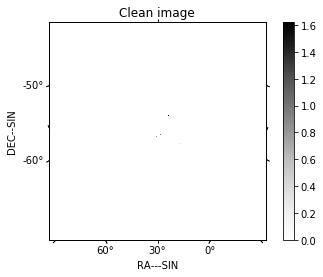

Quality assessment:
	Origin: qa_image
	Context: Residual clean image
	Data:
		shape: '(1, 1, 384, 384)'
		max: '0.11021284419355096'
		min: '-0.05548446000714187'
		rms: '0.01555985852141744'
		sum: '-7.3924340754613'
		medianabs: '0.009778520637297436'
		median: '-0.0007296075354873751'



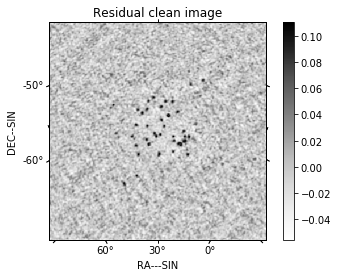

Quality assessment:
	Origin: qa_image
	Context: Restored clean image
	Data:
		shape: '(1, 1, 384, 384)'
		max: '2.008641139750777'
		min: '-0.05540343636410018'
		rms: '0.03741794810769717'
		sum: '253.12688482221932'
		medianabs: '0.009826954534481638'
		median: '-0.00064193620380825'



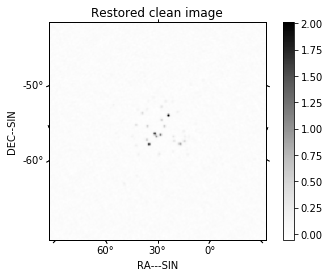

In [16]:
f = show_image(deconvolved, title='Clean image')
print(qa_image(deconvolved, context='Clean image'))
plt.show()
export_image_to_fits(deconvolved, '%s/imaging-ical_deconvolved.fits'
                     % (results_dir))

f = show_image(residual, title='Residual clean image')
print(qa_image(residual, context='Residual clean image'))
plt.show()
export_image_to_fits(residual, '%s/imaging-ical_residual.fits'
                     % (results_dir))

f = show_image(restored, title='Restored clean image')
print(qa_image(restored, context='Restored clean image'))
plt.show()
export_image_to_fits(restored, '%s/imaging-ical_restored.fits'
                     % (results_dir))